# Audio classification, with visualization and sonification of the results

This notebook is designed as the audio-equivalent of the [MNIST image classification exercise](MNIST.ipynb).
As you will see, audio can be processed very similarly to images, but with two modifications:

* Tensors are indexed as ```[index in batch,sample,channel]``` instead of ```[index in batch,x,y,channel]```
* Conv1D instead of Conv2D

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**
* Hard: based on the [adversarial training example](AdversarialMNIST.ipynb), try optimizing a sound that maximizes the activation output of some neuron. This might yield interesting sound textures.

Currently, we have no easy modifications to suggest. Feel free to invent your own!

## Loading and playing the data

First, let's load the dataset using a helper provided for the course and try playing a loaded sound in IPython.

In [1]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras 
from helpers.audio_loader import load_audio 
import IPython 
print(os.getcwd())

#Load the audio dataset. The course repository includes a small subset of this drum sound set: 
#http://deepyeti.ucsd.edu/cdonahue/wavegan/data/drums.tar.gz
nClasses=3
(x_train, y_train), (x_test, y_test) = load_audio("drums_subset_preprocessed", num_classes=nClasses, inputpath="../Datasets/")

#Play a sound. 
#IPython.display.Audio can play audio stored as Numpy arrays if you specify the sampling rate.
#The method expects 1D vectors, which is why we need to index as [sample number,:,channel],
#where the : denotes that we play the whole sound and not just a part of it.
IPython.display.Audio(x_train[0,:,0],rate=16000,autoplay=True)


c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


c:\CondaEnvs\tensorflow2\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\CondaEnvs\tensorflow2\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


c:\Git\MediaAI\Code\Jupyter
Loading soundset number 1
533 sounds in category kick
Loading soundset number 2
66 sounds in category ride
Loading soundset number 3
794 sounds in category snare
0 * 1.0 is 0.0
max is 16000
x_train shape: (1113, 16000, 1)
y_train shape: (1113, 3)
x_test shape: (280, 16000, 1)
y_test shape: (280, 3)
1113 train samples
280 test samples
Saving arrays to file


In [2]:
#Let's import the layer types we need
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Flatten #converts images to vectors of numbers

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Flatten converts a batch of multidimensional data into a batch of 1D data. 
#This is what the fully connected layers expect.
#For example, the rows of an image are simply stacked after each other.
#If the data was not images, we would not need this.
model.add(Flatten())

#The audio classification is so much harder that we need to have at least a
#few layers. Just the final 3-neuron layer, we won't learn anything
model.add(Dense(64,activation="relu"))
model.add(Dense(64,activation="relu"))

#The output layer is fully connected, with 1 neuron for each 10 classes.
#For classification, one should use the softmax activation.
#This means that each output neuron can be thought as the probability of a class.
model.add(Dense(nClasses, activation='softmax'))

#Compile the model. Note that now y_test is one-hot vectors instead of indices.
#Thus, categorical_crossentropy loss instead of sparse_categorical_crossentropy.
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 1113 samples, validate on 280 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1113/1113 [==============================] - 1s 980us/sample - loss: 7.4465 - acc: 0.5364 - val_loss: 6.8502 - val_acc: 0.5750

In [3]:
#Sonify some of the first layer neuron weights
#First, query the weights. We use index 1 because index 0 is the flatten layer
weights=model.layers[1].get_weights()[0]
#Create a figure with appropriate size
nNeuronsToSonify=10
#Loop over the neurons
for i in range(nNeuronsToSonify):
    #Weights is a 2D tensor where the first dimension indexes over data variables, second over neurons
    sound=weights[:,i]
    #Reshape and play
    sound=np.reshape(sound,sound.shape[0])
    #Here, as we want to show multiple audio playback widgets, we have to use
    #the IPython.display.display() around the IPython.display.Audio()
    IPython.display.display(IPython.display.Audio(sound,rate=16000))


## A convolutional neural network for audio
The classification accuracy of the fully connected network is very poor. Let's try the same with a convolutional neural network.

In [4]:
#Let's import the layer types we need
#import tensorflow.keras.layers.Layer
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Conv1D  #convolutional layer with 1D filters
from tensorflow.keras.layers import Flatten #converts images to plain vectors of numbers
from tensorflow.keras.layers import Dropout #this mitigates overfitting

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#First convolutional layer. Here, the kernels are 1D tensors, and we can use
#9 wide ones instead of the 5x5 and 3x3 we used in image classification. 
#Larger kernels are typically a bit better but use much more computing resources.
#With 1D convolutions, the cost 
kernelSize=9
model.add(Conv1D(16, kernel_size=kernelSize, strides=2,activation='relu',
                 input_shape=(x_train.shape[1],x_train.shape[2],)))

#Now, let's add more convolutional layers until the temporal dimension of the output is small enough
while model.layers[-1].output.shape[1]>kernelSize*2:
    model.add(Conv1D(32, kernel_size=kernelSize, activation='relu', strides=2))
    
#Fully connected part
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))

#Compile the model. 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 1113 samples, validate on 280 samples
Epoch 1/5
1113/1113 [==============================] - 15s 14ms/sample - loss: 1.1465 - acc: 0.5319 - val_loss: 0.7376 - val_acc: 0.7071

Let's test the classifier with a sound

In [5]:
#this is the test image
testIdx=82

#We index by testIdx:testIdx+1 to pass a batch of one image to the network instead of just one image
classProbabilities=model.predict(x_test[testIdx:testIdx+1])
print("Predicted class probabilities: ",classProbabilities)

#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
classes=["Kick","Ride","Snare"]
print("The most probable class is {}, with probability {}".format(classes[np.argmax(classProbabilities)],np.max(classProbabilities)))

IPython.display.Audio(x_test[testIdx,:,0],rate=16000,autoplay=True)


Predicted class probabilities:  [[0.00463789 0.92086834 0.07449376]]
The most probable class is Ride, with probability 0.9208683371543884


Now, let's try to see what the network has learned. With image classification, we could show the convolution filters as images. Here, we can't simply play them as audio, as they are only 5 values, whereas a second of audio is 16000 values in our dataset. Thus, we simply plot them as curves

Visualizing layer 0 kernel, shape (9, 1, 16)


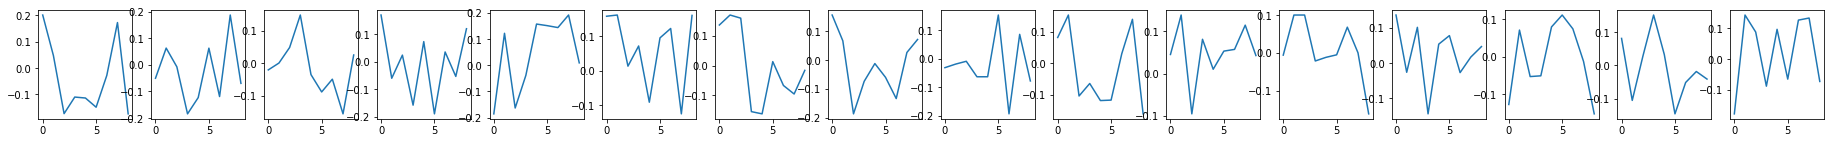

In [6]:
#Define a visualization helper

def visualizeLayerWeights(model,layerIndex):
    #Get the neuron weights, i.e., convolution kernels or filters
    kernel=model.layers[layerIndex].get_weights()[0]
    #Check the shape
    print("Visualizing layer {} kernel, shape {}".format(layerIndex,kernel.shape))
    #Visualize 16 first filters
    nFiltersToVisualize=16
    pp.figure(1,figsize=[nFiltersToVisualize*2,2])  #specify figsize explicitly because otherwise the images will be too small
    for i in range(nFiltersToVisualize):
        pp.subplot(1,nFiltersToVisualize,1+i)
        pp.plot(kernel[:,0,i])
    pp.show()
    
#visualize first layer
visualizeLayerWeights(model,0)
        
